In [154]:
# Load pickled data
import pickle
import tensorflow as tf
from sklearn.utils import shuffle
# TODO: Fill this in based on where you saved the training and testing data

training_file = "./train.p"
testing_file = "./test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (39209, 32, 32, 3)
y_train shape: (39209,)
X_test shape: (12630, 32, 32, 3)
y_test shape: (12630,)


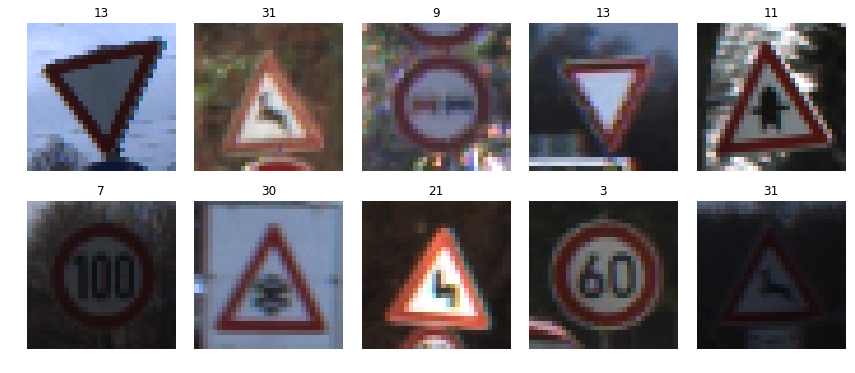

In [155]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import random
# Visualizations will be shown in the notebook.
%matplotlib inline

# show image of 10 random data points
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(10):
    index = random.randint(0, len(X_train))
    image = X_train[index]
    axs[i].axis('off')
    axs[i].imshow(image)
    axs[i].set_title(y_train[index])


In [156]:
### Replace each question mark with the appropriate value.
import numpy as np

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


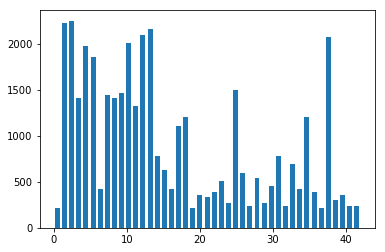

In [157]:
# histogram of label frequency
hist, bins = np.histogram(y_train, bins=n_classes)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

In [158]:
# Convert to grayscale
X_train_rgb = X_train
X_train_grey_scale = np.sum(X_train/3, axis=3, keepdims=True)

X_test_rgb = X_test
X_test_grey_scale = np.sum(X_test/3, axis=3, keepdims=True)

print('RGB shape:', X_train_rgb.shape)
print('Grayscale shape:', X_train_grey_scale.shape)

RGB shape: (39209, 32, 32, 3)
Grayscale shape: (39209, 32, 32, 1)


In [159]:
X_train = X_train_grey_scale
X_test = X_test_grey_scale
print('.....')

.....


In [160]:
X_train_normalized = (X_train - 128)/128 
X_test_normalized = (X_test - 128)/128

print(np.mean(X_train_normalized))
print(np.mean(X_test_normalized))

-0.354179278547
-0.358215153428


In [161]:
# Splitting the training dataset into training and validation data
from sklearn.model_selection import train_test_split

# Shuffle the data prior to splitting
X_train, y_train = shuffle(X_train, y_train)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, stratify = y_train, test_size=0.1, random_state=23)

print('Dataset successfully split for training and validation.')

Dataset successfully split for training and validation.


In [162]:
### Generate additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

# I will generate some additional data, then split the data in a later cell.
# This is to help with the issue identified in the original histogram
from scipy import ndimage
import random

# min_desired below is just mean_pics but wanted to make the code below easier to distinguish
pics_in_class = np.bincount(y_train)
mean_pics = int(np.mean(pics_in_class))
min_desired = int(mean_pics)

print('Generating new data.')

# Angles to be used to rotate images in additional data made
angles = [-10, 10, -15, 15, -20, 20]

# Iterate through each class
for i in range(len(pics_in_class)):
    
    # Check if less data than the mean
    if pics_in_class[i] < min_desired:
        
        # Count how many additional pictures we want
        new_wanted = min_desired - pics_in_class[i]
        picture = np.where(y_train == i)
        more_X = []
        more_y = []
        
        # Make the number of additional pictures needed to arrive at the mean
        for num in range(new_wanted):
            
            # Rotate images and append new ones to more_X, append the class to more_y
            more_X.append(ndimage.rotate(X_train[picture][random.randint(0,pics_in_class[i] - 1)], random.choice(angles), reshape=False))
            more_y.append(i)
        
        # Append the pictures generated for each class back to the original data
        X_train = np.append(X_train, np.array(more_X), axis=0)
        y_train = np.append(y_train, np.array(more_y), axis=0)
        
print('Additional data generated. Any classes lacking data now have', min_desired, 'pictures.')

Generating new data.
Additional data generated. Any classes lacking data now have 820 pictures.


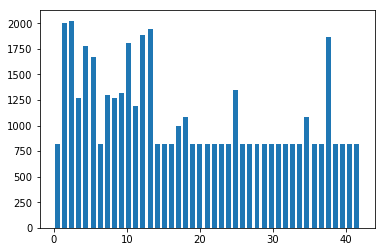

In [163]:
# histogram of label frequency
hist, bins = np.histogram(y_train, bins=n_classes)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

In [164]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

# The below is only necessary to reset if the notebook has not been shutdown
tf.reset_default_graph()

EPOCHS = 10
BATCH_SIZE = 150

from tensorflow.contrib.layers import flatten

def neural_network(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    # Weight and bias
    # If not using grayscale, the third number in shape would be 3
    c1_weight = tf.Variable(tf.truncated_normal(shape = (5, 5, 1, 6), mean = mu, stddev = sigma))
    c1_bias = tf.Variable(tf.zeros(6))
    # Apply convolution
    conv_layer1 = tf.nn.conv2d(x, c1_weight, strides=[1, 1, 1, 1], padding='VALID') + c1_bias
    
    # Activation for layer 1
    conv_layer1 = tf.nn.relu(conv_layer1)
    
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv_layer1 = tf.nn.avg_pool(conv_layer1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Layer 2: Convolutional. Output = 10x10x16.
    # Note: The second layer is implemented the exact same as layer one, with layer 1 as input instead of x
    # And then of course changing the numbers to fit the desired ouput of 10x10x16
    # Weight and bias
    c2_weight = tf.Variable(tf.truncated_normal(shape = (5, 5, 6, 16), mean = mu, stddev = sigma))
    c2_bias = tf.Variable(tf.zeros(16))
    # Apply convolution for layer 2
    conv_layer2 = tf.nn.conv2d(conv_layer1, c2_weight, strides=[1, 1, 1, 1], padding='VALID') + c2_bias
    
    # Activation for layer 2
    conv_layer2 = tf.nn.relu(conv_layer2)
    
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv_layer2 = tf.nn.avg_pool(conv_layer2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten to get to fully connected layers. Input = 5x5x16. Output = 400.
    flat = tf.contrib.layers.flatten(conv_layer2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    # Although this is fully connected, the weights and biases still are implemented similarly
    # There is no filter this time, so shape only takes input and output
    # Weight and bias
    fc1_weight = tf.Variable(tf.truncated_normal(shape = (400, 200), mean = mu, stddev = sigma))
    fc1_bias = tf.Variable(tf.zeros(200))
    # Here is the main change versus a convolutional layer - matrix multiplication instead of 2D convolution
    fc1 = tf.matmul(flat, fc1_weight) + fc1_bias
    
    # Activation for the first fully connected layer.
    # Same thing as before
    fc1 = tf.nn.relu(fc1)
    
    # Dropout, to prevent overfitting
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    # Same as the fc1 layer, just with updated output numbers
    fc2_weight = tf.Variable(tf.truncated_normal(shape = (200, 100), mean = mu, stddev = sigma))
    fc2_bias = tf.Variable(tf.zeros(100))
    # Again, matrix multiplication
    fc2 = tf.matmul(fc1, fc2_weight) + fc2_bias
    
    # Activation.
    fc2 = tf.nn.relu(fc2)
    
    # Dropout
    fc2 = tf.nn.dropout(fc2, keep_prob)
    
    # Layer 5 Fully Connected. Input = 84. Output = 43.
    # Since this is the final layer, output needs to match up with the number of classes
    fc3_weight = tf.Variable(tf.truncated_normal(shape = (100, 43), mean = mu, stddev = sigma))
    fc3_bias = tf.Variable(tf.zeros(43))
    # Again, matrix multiplication
    logits = tf.matmul(fc2, fc3_weight) + fc3_bias
    
    return logits

In [165]:
# Set placeholder variables for x, y, and the keep_prob for dropout
# Also, one-hot encode y
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

In [166]:
# Setting learning rate, loss functions, and optimizer
rate = 0.005
#logits = yPredbyNN, labels=Y
logits = neural_network(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [167]:
# The below is used in the validation part of the neural network
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy =  sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob : 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [168]:
### Train your model here.
### Feel free to use as many code cells as needed.

saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            loss = sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob : 0.7})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    # Save the model
    saver.save(sess, './lenet')
    print('Trained Model Saved.')

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Training...

EPOCH 1 ...
Validation Accuracy = 0.859

EPOCH 2 ...
Validation Accuracy = 0.939

EPOCH 3 ...
Validation Accuracy = 0.945

EPOCH 4 ...
Validation Accuracy = 0.950

EPOCH 5 ...
Validation Accuracy = 0.951

EPOCH 6 ...
Validation Accuracy = 0.954

EPOCH 7 ...
Validation Accuracy = 0.943

EPOCH 8 ...
Validation Accuracy = 0.964

EPOCH 9 ...
Validation Accuracy = 0.957

EPOCH 10 ...
Validation Accuracy = 0.965

Trained Model Saved.


In [169]:
 ##Launch the model on the test data
with tf.Session() as sess:
    saver.restore(sess, "./lenet")
    test_accuracy = sess.run(accuracy_operation, feed_dict={x: X_test, y: y_test, keep_prob : 1.0})
print('Test Accuracy: {}'.format(test_accuracy))

Test Accuracy: 0.9072842597961426


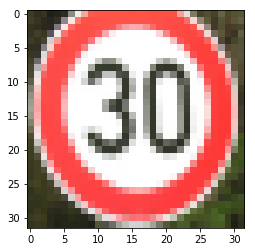

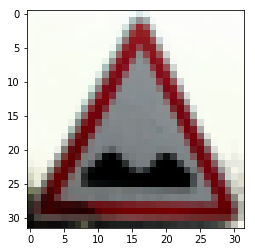

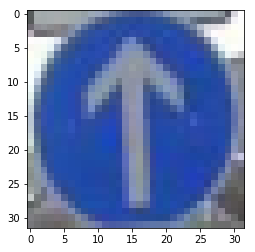

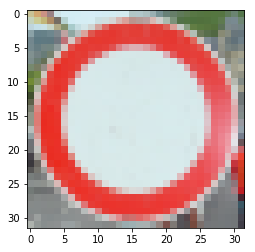

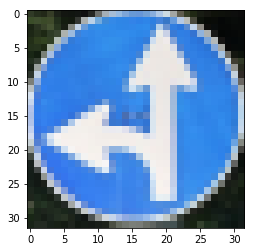

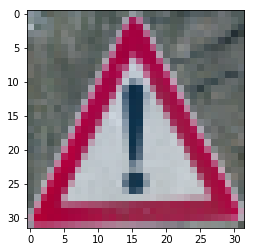

In [170]:
import glob
import cv2

my_images = sorted(glob.glob('./mysigns/*.png'))
my_labels = np.array([1, 22, 35, 15, 37, 18])
my_signs = []
index = 0
for my_image in my_images:
    my_signs.append(img)
for i in my_images:
    image = plt.imread(i)
    add_pics_data.append(image)
    plt.imshow(image)
    plt.show()

In [171]:
my_signs = np.array(my_signs)
my_signs_gray = np.sum(my_signs/3, axis=3, keepdims=True)
my_signs = my_signs_gray
my_signs_normalized = (my_signs - 128)/128
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
 ##Launch the model on the test data
with tf.Session() as sess:
    saver.restore(sess, "./lenet")
    test_accuracy = sess.run(accuracy_operation, feed_dict={x: my_signs, y: my_labels, keep_prob : 1.0})
print('Test Accuracy: {}'.format(test_accuracy))

Test Accuracy: 0.1666666716337204
